<a href="https://colab.research.google.com/github/susie682/Infosys722--Assignment-4-BDAS/blob/main/7_1_LogicalTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Info] Drive already mounted at /content/drive

Using CSV: /content/drive/MyDrive/Infosys 722/tables/CrimeData2017_reduced_projected.csv
Figures will be saved to: /content/drive/MyDrive/Infosys 722/figs
Loaded shape: (267, 15)
Columns: ['District', 'Month', 'Total', 'District_Month_ArrestRate', 'District_Month_DomesticRate', 'NightShare_DistMonth', 'OutdoorShare_DistMonth', 'Roll3Mean_DistMonth', 'y_count_next', 'District_Month_ArrestRate_logit', 'District_Month_DomesticRate_logit', 'NightShare_DistMonth_logit', 'OutdoorShare_DistMonth_logit', 'Roll3Mean_DistMonth_log1p', 'y_count_next_log1p']
[Info] Found 'Month' but not 'Year' — defaulting Year=2017 (project scope).
Train months: ['2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08']
Test months : ['2017-09', '2017-10', '2017-11']
Saved: /content/drive/MyDrive/Infosys 722/tables/table5_monthly_allocation.csv


Split,_ym,Test,Train,Train_share
0,2017-01,0,23,1.0
1,2017-02,0,22,1.0
2,2017-03,0,22,1.0
3,2017-04,0,22,1.0
4,2017-05,0,22,1.0
5,2017-06,0,22,1.0
6,2017-07,0,22,1.0
7,2017-08,0,22,1.0
8,2017-09,22,0,0.0
9,2017-10,22,0,0.0


Saved: /content/drive/MyDrive/Infosys 722/tables/table6_features_district_month_preview.csv
Saved: /content/drive/MyDrive/Infosys 722/figs/fig62_split_size.png


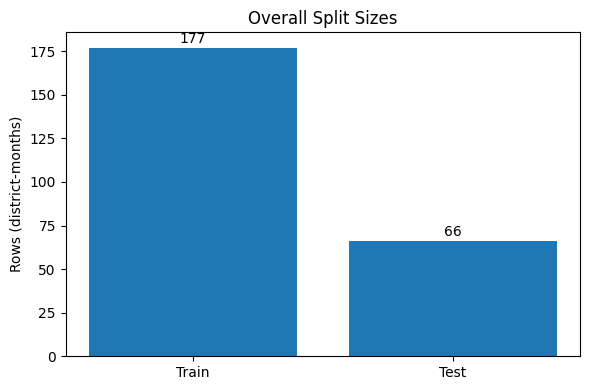

Saved: /content/drive/MyDrive/Infosys 722/figs/fig63_split_over_time.png


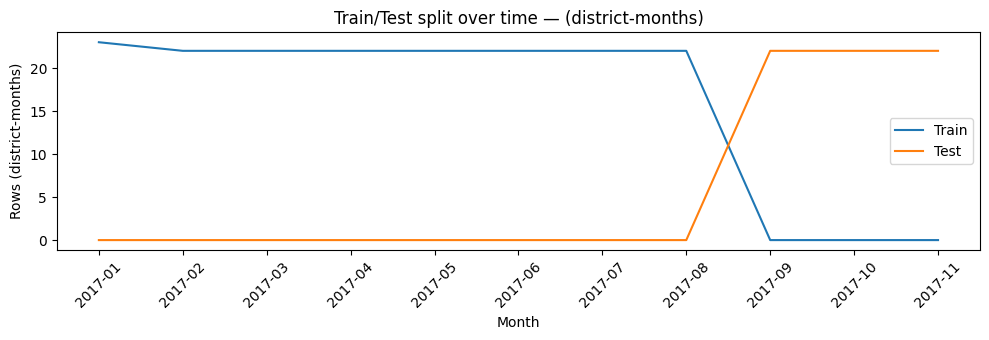

/tmp/ipython-input-1975852501.py:256: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(month_hotspot_share)


Saved: /content/drive/MyDrive/Infosys 722/figs/fig64_hotspot_prevalence.png


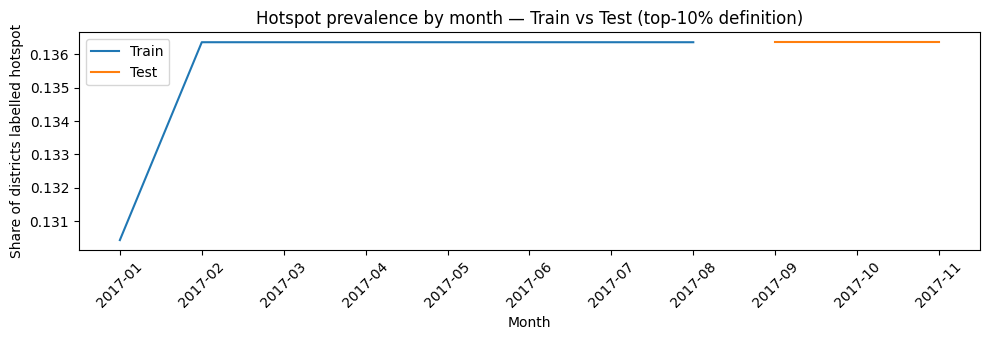


Done. Artifacts written to:
 - /content/drive/MyDrive/Infosys 722/tables/table5_monthly_allocation.csv
 - /content/drive/MyDrive/Infosys 722/tables/table6_features_district_month_preview.csv
 - /content/drive/MyDrive/Infosys 722/figs/fig62_split_size.png
 - /content/drive/MyDrive/Infosys 722/figs/fig63_split_over_time.png
 - /content/drive/MyDrive/Infosys 722/figs/fig64_hotspot_prevalence.png


In [7]:
# =========================
# 7.1 Logical Test Design — robust, Colab-safe
# =========================

import os, shutil, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------- 0) Safe Google Drive mount ----------------
def safe_mount_drive(mountpoint="/content/drive"):
    """Remove local placeholder dir if present and mount Drive once."""
    try:
        from google.colab import drive  # type: ignore
    except Exception:
        return False  # likely not in Colab
    if os.path.exists(mountpoint) and (not os.path.ismount(mountpoint)):
        print("[Info] Cleaning local placeholder at", mountpoint)
        shutil.rmtree(mountpoint)
    if not os.path.ismount(mountpoint):
        drive.mount(mountpoint)
        return True
    print("[Info] Drive already mounted at", mountpoint)
    return True

_ = safe_mount_drive("/content/drive")

# ---------------- 1) Resolve paths & locate CSV ----------------
ROOT   = "/content/drive/MyDrive/Infosys 722"
TAB_DIR = os.path.join(ROOT, "tables")
FIG_DIR = os.path.join(ROOT, "figs")
os.makedirs(TAB_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

TARGET_NAME = "CrimeData2017_reduced_projected.csv"
CSV_PATH = os.path.join(TAB_DIR, TARGET_NAME)

def find_csv(start_dir="/content/drive/MyDrive", filename_part=TARGET_NAME):
    """Search recursively under start_dir for a CSV whose name contains filename_part."""
    for dirpath, _, files in os.walk(start_dir):
        for f in files:
            if f.lower().endswith(".csv") and (filename_part.lower() in f.lower()):
                return os.path.join(dirpath, f)
    return None

if not os.path.exists(CSV_PATH):
    print(f"[Warn] Not found at expected path:\n  {CSV_PATH}")
    print("[Info] Searching your Drive for the file ...")
    found = find_csv("/content/drive/MyDrive", TARGET_NAME)
    if found:
        CSV_PATH = found
        print("[OK] Found CSV at:", CSV_PATH)
    else:
        print("[Error] Could not find the CSV anywhere under /content/drive/MyDrive.")
        if os.path.exists(TAB_DIR):
            print("\nFiles currently in", TAB_DIR)
            for fn in sorted(os.listdir(TAB_DIR)):
                print(" -", fn)
        raise FileNotFoundError("CSV missing — please upload it or correct the name.")

print("\nUsing CSV:", CSV_PATH)
print("Figures will be saved to:", FIG_DIR)

# ---------------- 2) Load data ----------------
df = pd.read_csv(CSV_PATH)
print("Loaded shape:", df.shape)
print("Columns:", list(df.columns))

# ---------------- 3) Ensure Year/Month robustly ----------------
def ensure_year_month(df_in: pd.DataFrame) -> pd.DataFrame:
    """Return df with valid integer Year and Month columns.
    Strategy:
      1) Look for explicit columns (case-insensitive) for year/month.
      2) Try to parse any date-like column (strings/datetimes).
      3) Detect YYYYMM (integer) or 'YYYY-MM' style columns.
      4) If only Month found, default Year=2017 (project scope).
    """
    df = df_in.copy()

    # Map lowercase->original for easy lookup
    name_map = {c.lower().strip(): c for c in df.columns}

    def get_col(candidates):
        for cand in candidates:
            if cand in name_map:
                return name_map[cand]
        return None

    # 3.1 Try explicit year/month name variants
    year_col  = get_col(["year","yr","yyyy"])
    month_col = get_col(["month","mnth","mth","mon","mo","month_num","monthnumber"])

    # 3.2 If missing, try to parse any object column as datetime
    parsed_ok = None
    if year_col is None or month_col is None:
        for c in df.columns:
            s = df[c]
            # Try YYYYMM as int (e.g., 201701)
            if pd.api.types.is_integer_dtype(s) or pd.api.types.is_float_dtype(s):
                if s.notna().any():
                    vals = s.dropna().astype(int)
                    if ((vals >= 201701) & (vals <= 201712)).mean() > 0.8:
                        dt = pd.to_datetime(vals.astype(str), format="%Y%m", errors="coerce")
                        if dt.notna().mean() > 0.8:
                            df["Year"]  = dt.dt.year
                            df["Month"] = dt.dt.month
                            parsed_ok = True
                            break
            # Try string-like date columns
            if pd.api.types.is_object_dtype(s) or pd.api.types.is_string_dtype(s):
                dt = pd.to_datetime(s, errors="coerce")
                if dt.notna().mean() > 0.8:
                    df["Year"]  = dt.dt.year
                    df["Month"] = dt.dt.month
                    parsed_ok = True
                    break

    # 3.3 If still missing, consider 'YYYY-MM' pattern in any string column
    if parsed_ok is None and (year_col is None or month_col is None):
        regex = re.compile(r"^\s*2017[-/._ ]?(0[1-9]|1[0-2])\s*$")
        for c in df.columns:
            if pd.api.types.is_object_dtype(df[c]) or pd.api.types.is_string_dtype(df[c]):
                sample = df[c].dropna().astype(str).head(50)
                if len(sample) > 0 and (sample.str.match(regex).mean() > 0.6):
                    dt = pd.to_datetime(df[c].astype(str).str.replace(r"[^\d]", "", regex=True),
                                        format="%Y%m", errors="coerce")
                    if dt.notna().mean() > 0.8:
                        df["Year"]  = dt.dt.year
                        df["Month"] = dt.dt.month
                        parsed_ok = True
                        break

    # 3.4 Use explicit columns if present
    if "Year" not in df.columns and year_col is not None:
        df["Year"] = pd.to_numeric(df[year_col], errors="coerce")
    if "Month" not in df.columns and month_col is not None:
        df["Month"] = pd.to_numeric(df[month_col], errors="coerce")

    # 3.5 If only Month exists, default Year=2017 (dataset scope)
    if "Month" in df.columns and "Year" not in df.columns:
        print("[Info] Found 'Month' but not 'Year' — defaulting Year=2017 (project scope).")
        df["Year"] = 2017

    # Final checks
    if "Year" not in df.columns or "Month" not in df.columns:
        print("[Debug] Available columns:", list(df.columns))
        raise ValueError("Could not infer Year/Month — please add columns or a parseable date field.")

    df["Year"]  = pd.to_numeric(df["Year"], errors="coerce").astype(int)
    df["Month"] = pd.to_numeric(df["Month"], errors="coerce").astype(int)
    if not df["Month"].between(1,12).all():
        raise ValueError("Month values must be in 1..12 after parsing.")

    return df

df = ensure_year_month(df)

# Ensure other essentials
if "District" not in df.columns or "Total" not in df.columns:
    raise ValueError("Dataset must contain 'District' and 'Total' columns.")
df["District"] = df["District"].astype(str).str.strip()

# Year-Month label
df["_ym"] = pd.to_datetime(dict(year=df["Year"], month=df["Month"], day=1)).dt.strftime("%Y-%m")

# ---------------- 4) Next-month target ----------------
if "y_count_next" in df.columns:
    df["y_next"] = pd.to_numeric(df["y_count_next"], errors="coerce")
else:
    df = df.sort_values(["District","Year","Month"]).copy()
    df["y_next"] = df.groupby("District")["Total"].shift(-1)

df = df.dropna(subset=["y_next"]).copy()
df["y_next"] = df["y_next"].astype(float)

# ---------------- 5) Time-ordered split ----------------
timeline  = df[["_ym","Year","Month"]].drop_duplicates().sort_values(["Year","Month"])
unique_ym = list(timeline["_ym"])
if len(unique_ym) < 4:
    raise ValueError("Not enough months to form a train/test split.")

test_months  = unique_ym[-3:]   # last 3 months → Test
train_months = unique_ym[:-3]   # rest → Train
df["Split"]  = np.where(df["_ym"].isin(test_months), "Test", "Train")

print("Train months:", train_months)
print("Test months :", test_months)

# ---------------- 6) Table 5 ----------------
tab5 = (
    df.pivot_table(index="_ym", columns="Split", values="District",
                   aggfunc="count", fill_value=0)
      .reset_index()
      .sort_values("_ym")
)
tab5["Train_share"] = tab5.get("Train",0) / (tab5.get("Train",0)+tab5.get("Test",0)).replace(0, np.nan)
tab5["Train_share"] = tab5["Train_share"].fillna(0)
tab5_path = os.path.join(TAB_DIR, "table5_monthly_allocation.csv")
tab5.to_csv(tab5_path, index=False)
print("Saved:", tab5_path)
display(tab5.head(12))

# ---------------- 7) Table 6 (preview) ----------------
preview_cols = [c for c in df.columns if c != "Split"]
tab6_preview = df[preview_cols].head(244).copy()
tab6_path = os.path.join(TAB_DIR, "table6_features_district_month_preview.csv")
tab6_preview.to_csv(tab6_path, index=False)
print("Saved:", tab6_path)

# ---------------- 8) Figure 62: split size ----------------
counts = df["Split"].value_counts().reindex(["Train","Test"]).fillna(0).astype(int)
fig, ax = plt.subplots(figsize=(6,4))
bars = ax.bar(counts.index, counts.values)
for b in bars:
    ax.text(b.get_x()+b.get_width()/2, b.get_height()+1, f"{int(b.get_height())}",
            ha="center", va="bottom")
ax.set_ylabel("Rows (district-months)")
ax.set_title("Overall Split Sizes")
fig.tight_layout()
out62 = os.path.join(FIG_DIR, "fig62_split_size.png")
fig.savefig(out62, dpi=150, bbox_inches="tight")
print("Saved:", out62)
plt.show()

# ---------------- 9) Figure 63: split over time ----------------
by_month = (
    df.groupby(["_ym","Split"])["District"].count()
      .unstack("Split").fillna(0)
      .reindex(unique_ym)
)
fig, ax = plt.subplots(figsize=(10,3.5))
ax.plot(by_month.index, by_month.get("Train",0).values, label="Train")
ax.plot(by_month.index, by_month.get("Test",0).values,  label="Test")
ax.set_title("Train/Test split over time — (district-months)")
ax.set_ylabel("Rows (district-months)")
ax.set_xlabel("Month")
ax.legend()
ax.tick_params(axis="x", rotation=45)
fig.tight_layout()
out63 = os.path.join(FIG_DIR, "fig63_split_over_time.png")
fig.savefig(out63, dpi=150, bbox_inches="tight")
print("Saved:", out63)
plt.show()

# ---------------- 10) Figure 64: hotspot prevalence ----------------
K = 0.10  # top 10% per month by y_next
def month_hotspot_share(frame):
    n = frame["District"].nunique()
    k = max(int(np.ceil(K * n)), 1)
    order  = frame.sort_values("y_next", ascending=False)
    top_id = set(order["District"].head(k))
    return frame["District"].isin(top_id).astype(int).mean()

shares = (
    df.groupby(["_ym","Split"])
      .apply(month_hotspot_share)
      .rename("hotshare").reset_index()
      .pivot(index="_ym", columns="Split", values="hotshare")
      .reindex(unique_ym)
)

fig, ax = plt.subplots(figsize=(10,3.5))
ax.plot(shares.index, shares.get("Train",0).values, label="Train")
ax.plot(shares.index, shares.get("Test",0).values,  label="Test")
ax.set_title("Hotspot prevalence by month — Train vs Test (top-10% definition)")
ax.set_ylabel("Share of districts labelled hotspot")
ax.set_xlabel("Month")
ax.legend()
ax.tick_params(axis="x", rotation=45)
fig.tight_layout()
out64 = os.path.join(FIG_DIR, "fig64_hotspot_prevalence.png")
fig.savefig(out64, dpi=150, bbox_inches="tight")
print("Saved:", out64)
plt.show()

print("\nDone. Artifacts written to:")
print(" -", tab5_path)
print(" -", tab6_path)
print(" -", out62)
print(" -", out63)
print(" -", out64)
